In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import mixture
from sklearn.decomposition import PCA
import time
import sys
import scipy.ndimage
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from matplotlib.colors import LogNorm
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
#%matplotlib notebook
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)
import warnings
warnings.filterwarnings(action='once')
import pickle

In [2]:
with open("robust_1.bin", "rb") as f:
    df = pickle.load(f)
    
features = df["features"]
T = df["T"]
Tsec = df["Tsec"]
frame_w = df["frame_w"]
frame_h = df["frame_h"]
    
Ny, Nx, Nbins = features[0][2].shape
Ndirs = Nbins - 1
cell_size = int(frame_w / Nx)
assert(cell_size == int(frame_h / Ny))

Nt = len(features)

bcd_arr = []

for i in range(Nt):
    bcd_arr.append(features[i][2])
    
bcd_arr = np.array(bcd_arr)    

print("bcd_arr.shape", bcd_arr.shape)
print("Nt", Nt)
print("Nx, Ny, Ndirs", Nx, Ny, Ndirs)
print("h, w, T", frame_w, frame_h, T)
print("cell_size", cell_size)

bcd_arr.shape (10, 15, 20, 9)
Nt 10
Nx, Ny, Ndirs 20 15 8
h, w, T 320 240 50
cell_size 16


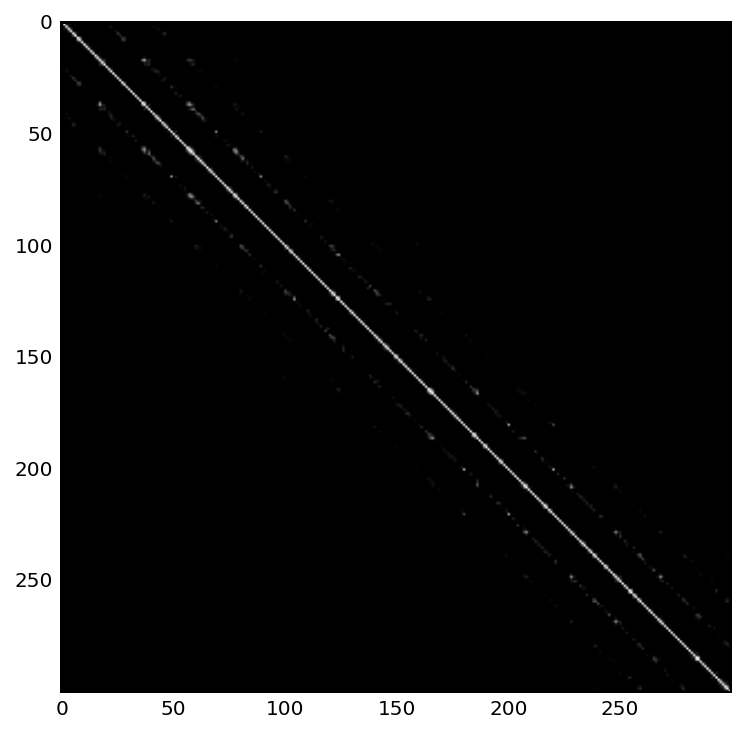

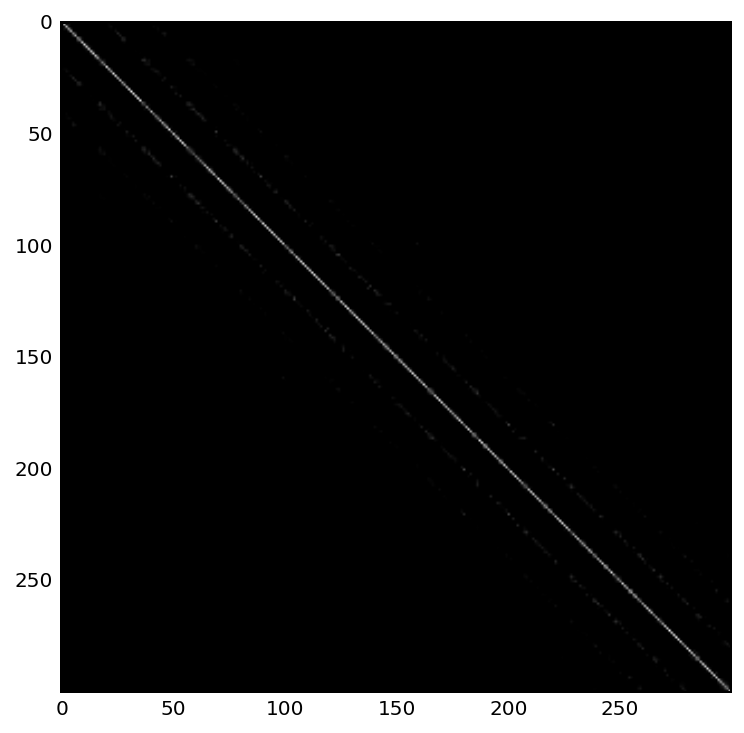

In [12]:
Ncells = Nx * Ny
R = 111111115.0

def cell2xy(idx):
    y = int(idx / Nx)
    x = idx - y * Nx
    return np.array([np.float64(x), np.float64(y)])

Dij_bcd = np.zeros((Ncells, Ncells), np.float64)
Dij_dist = np.zeros((Ncells, Ncells), np.float64)

for i in range(Ncells):
    for j in range(Ncells):
        ci = cell2xy(i)
        cj = cell2xy(j)
        mag = np.linalg.norm(ci - cj)
        bcd1 = bcd_arr[:, int(ci[1]), int(ci[0]), :]
        bcd2 = bcd_arr[:, int(cj[1]), int(cj[0]), :]                                                
        Dij_bcd[i, j] = distance.cosine(bcd1.flatten(), bcd2.flatten())
        #Dij_bcd[i, j] = np.linalg.norm(bcd1.flatten() - bcd2.flatten())
        Dij_dist[i, j] = mag
            
Aij = np.zeros((Ncells, Ncells), np.float64)
        
sigmaBCD = np.zeros(Aij.shape[0], np.float64)
sigmaDIST = np.zeros(Aij.shape[0], np.float64)
for i in range(Aij.shape[0]):
    row = np.sort(Dij_bcd[i, :])
    row = np.trim_zeros(row)
    sigmaBCD[i] = row[6]
    
    #row = Dij_bcd[i, :]
    #gm1 = GaussianMixture(n_components=1, covariance_type='diag')    
    #gm1.fit(row.reshape(-1, 1))
    #sigmaBCD[i] = gm1.covariances_[0][0]
    
    row = np.sort(Dij_dist[i, :])
    row = np.trim_zeros(row)
    sigmaDIST[i] = row[6]
    
    #row = Dij_dist[i, :]
    #gm1 = GaussianMixture(n_components=1, covariance_type='diag')    
    #gm1.fit(row.reshape(-1, 1))
    #sigmaDIST[i] = gm1.covariances_[0][0]
    
for i in range(Aij.shape[0]):
    for j in range(Aij.shape[0]):
        ci = cell2xy(i)
        cj = cell2xy(j)        
        mag = np.linalg.norm(ci - cj)
        if (mag <= R):            
            Aij[i, j] = np.exp((-1.0 * (Dij_bcd[i,j]**2.0)) / (sigmaBCD[i] * sigmaBCD[j]) +
                               (-1.0 * (Dij_dist[i,j]**2.0)) / (sigmaDIST[i] * sigmaDIST[j]))
        else:
            Aij[i, j] = 10000
            
plt.figure()
plt.imshow(Aij, cmap='gray')
plt.show()

D = np.diag(Aij.sum(axis=1)**-0.5)
                
_L = np.dot(D,Aij)
L = np.dot(_L,D)
Anorm = L

plt.figure()
plt.imshow(Anorm, cmap='gray')
plt.show()

87


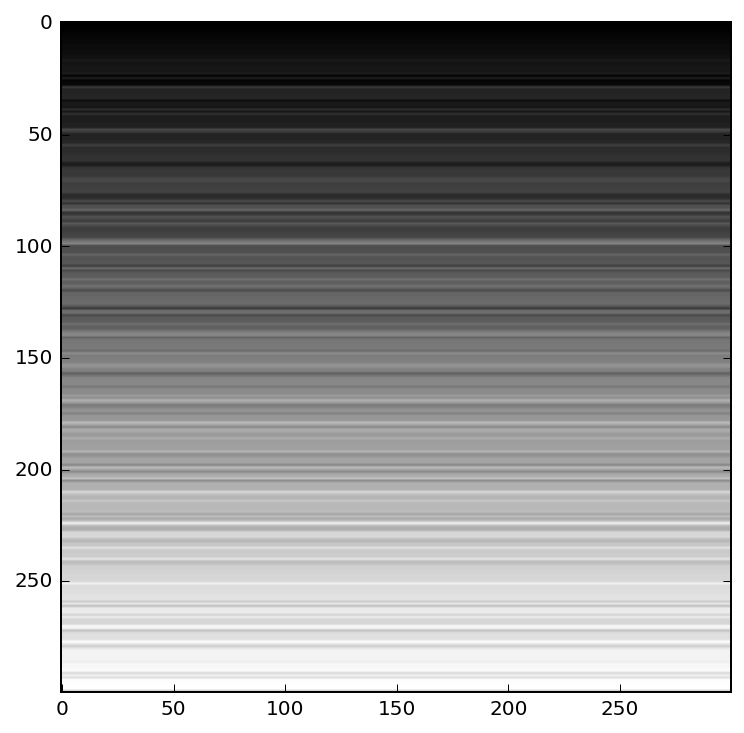

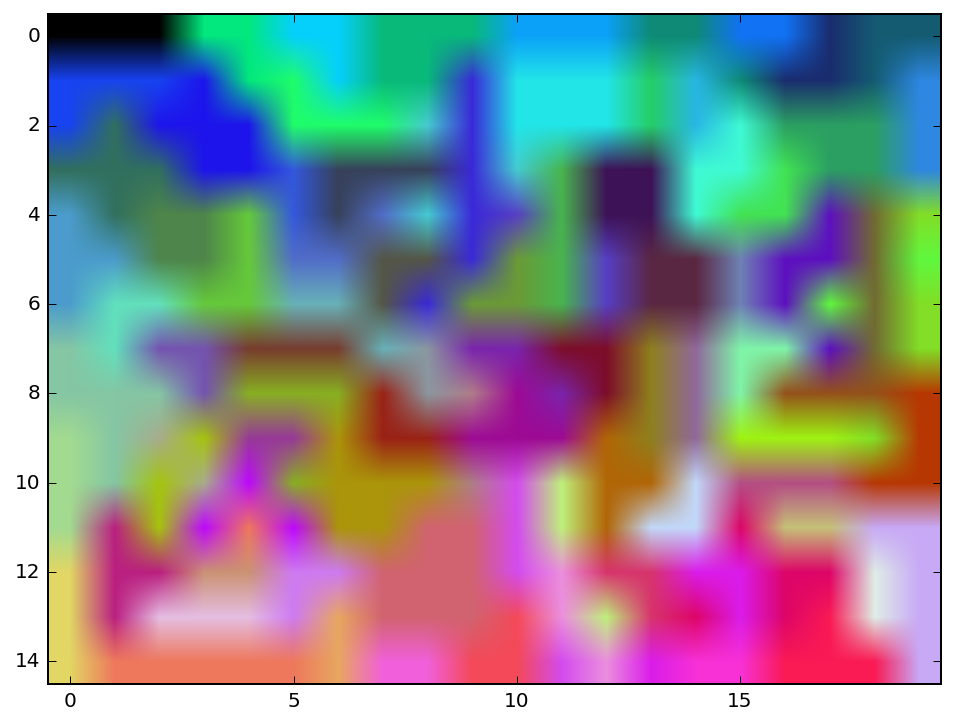

In [14]:
from sklearn.cluster import AffinityPropagation

def get_spaced_colors(n):
    max_value = 16581375 #255**3
    interval = int(max_value / n)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]
    
    return [(int(i[:2], 16), int(i[2:4], 16), int(i[4:], 16)) for i in colors]

af = AffinityPropagation(affinity='precomputed').fit(Aij)

finalK2 = len(af.cluster_centers_indices_)
print(finalK2)

AM = np.zeros((Ncells, Ncells), np.float64)
for i in range(Ncells):            
    for j in range(Ncells):            
        AM[i, j] = af.labels_[i]
            
plt.figure()
plt.imshow(AM, cmap='gray')
plt.show()

clrs = np.zeros((Ny, Nx, 3), np.uint8)

cc = get_spaced_colors(finalK2)

for i in range(finalK2):
    for j in range(Ncells):
        if af.labels_[j] == i:
            c = cell2xy(j)
            clrs[int(c[1]), int(c[0]), 0] = cc[i][0]
            clrs[int(c[1]), int(c[0]), 1] = cc[i][1]
            clrs[int(c[1]), int(c[0]), 2] = cc[i][2]
            
plt.figure()
plt.imshow(clrs)
plt.show()